## POS tagging using modified Viterbi


### HMMs and Viterbi algorithm for POS tagging.
### Modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques.

### Data Preparation

In [290]:
#Importing libraries
import nltk
import random
from sklearn.model_selection import train_test_split

from collections import Counter
import numpy as np
import pandas as pd
import pprint, time

from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

In [291]:
# Reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [292]:
# first few tagged sentences
print(nltk_data[:2])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]


In [293]:
## Frequency Distribution

tag_words = [tup for sent in nltk_data for tup in sent]
print (len(tag_words))
tag_fd = nltk.FreqDist(tag for (word, tag) in tag_words)
tag_fd.most_common()

100676


[('NOUN', 28867),
 ('VERB', 13564),
 ('.', 11715),
 ('ADP', 9857),
 ('DET', 8725),
 ('X', 6613),
 ('ADJ', 6397),
 ('NUM', 3546),
 ('PRT', 3219),
 ('ADV', 3171),
 ('PRON', 2737),
 ('CONJ', 2265)]

In [294]:
## Checking the Frequency count using Counter

tag_counts = Counter([tag[1] for sent in nltk_data for tag in sent])
print (tag_counts)

Counter({'NOUN': 28867, 'VERB': 13564, '.': 11715, 'ADP': 9857, 'DET': 8725, 'X': 6613, 'ADJ': 6397, 'NUM': 3546, 'PRT': 3219, 'ADV': 3171, 'PRON': 2737, 'CONJ': 2265})


## Insert the 95% train & 5% validation as stated in the problem statement

In [295]:
## Splitting into train and test
## 95% train & 5% test

random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
#print(train_set[:40])

3718
196


In [296]:
## Getting list of tagged words

train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95699

In [297]:
## Get the list of all the words

tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Preston', 'G.', 'Foster', 'Birmingham', ',', 'Ala', '.', '``', 'Cosby', "''"]

In [298]:
## unique word list in the training corpus

V = set(tokens)

print(len(V))

12101


In [299]:
## Unique number of tags in the corpus

T = set([pair[1] for pair in train_tagged_words])
print (len(T))
print (T)


12
{'VERB', 'NOUN', 'ADJ', 'DET', 'ADP', 'NUM', 'X', 'CONJ', 'PRT', 'PRON', '.', 'ADV'}


In [300]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
#w_given_t = np.zeros((t, v))

# Emission Probability

In [301]:
# Emission Probability - 
## for given word-tag, ratio of the number of times the word is tagged with the specific tag by
## the number of words in the training corpus

def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)

    return (count_w_given_tag, count_tag)

# Transition Probability

In [302]:
## Transitions Probability -
## 

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [303]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [304]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [305]:
tags_df

,VERB,NOUN,ADJ,DET,ADP,NUM,X,CONJ,PRT,PRON,.,ADV
VERB,0.168324,0.109756,0.065558,0.134069,0.091813,0.022371,0.218269,0.005282,0.031303,0.035343,0.035110,0.082803
NOUN,0.147047,0.264474,0.012336,0.013100,0.176304,0.009534,0.028820,0.043303,0.044067,0.004767,0.239475,0.016775
ADJ,0.011513,0.699342,0.066776,0.004770,0.077467,0.021217,0.020724,0.016941,0.011020,0.000658,0.064803,0.004770
DET,0.039604,0.640063,0.204419,0.005433,0.009297,0.022217,0.044434,0.000483,0.000241,0.003502,0.017749,0.012557
ADP,0.008658,0.323536,0.106563,0.323856,0.016888,0.061992,0.034096,0.000855,0.001389,0.068726,0.040402,0.013040
NUM,0.018392,0.353604,0.032631,0.003263,0.034411,0.185998,0.212993,0.013942,0.026698,0.001483,0.113913,0.002670
X,0.202265,0.062211,0.016271,0.055511,0.144202,0.002552,0.074813,0.010368,0.185676,0.056149,0.164620,0.025363
CONJ,0.159059,0.349470,0.117566,0.118949,0.053020,0.041955,0.008299,0.000461,0.004149,0.056708,0.035500,0.054864
PRT,0.401305,0.247961,0.084829,0.101794,0.019576,0.056770,0.012724,0.002284,0.001958,0.018923,0.042088,0.009788
PRON,0.484755,0.210343,0.073717,0.010035,0.022385,0.007333,0.091856,0.005017,0.012350,0.006947,0.041297,0.033964


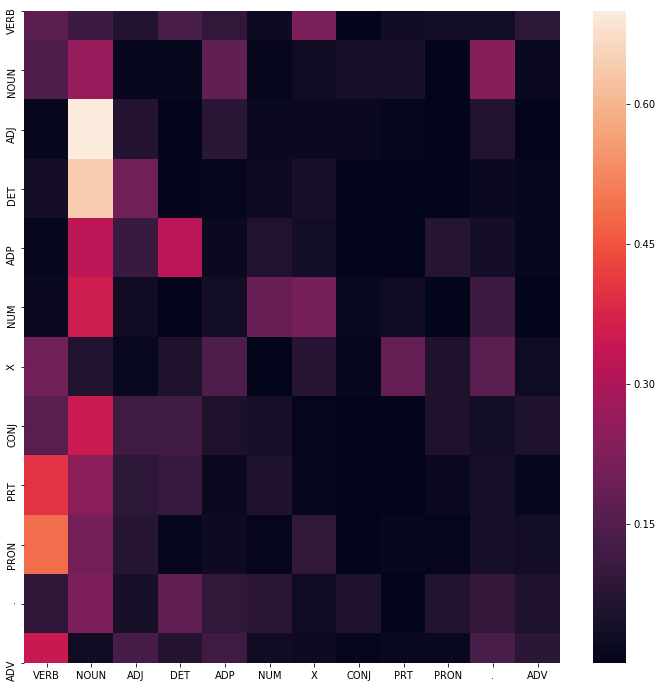

In [306]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(12, 12))
sns.heatmap(tags_df)
plt.show()


In [307]:
print (t2_given_t1 ('NOUN', 'DET'))
print (t2_given_t1 ('NOUN', 'ADJ'))

(5301, 8282)
(4252, 6080)


### Build the vanilla Viterbi based POS tagger

In [308]:
len(train_tagged_words)

95699

# Vanilla Viterbi Heuristic

In [309]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


# Creating a test sample of only 10 sentences

In [310]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(10)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('The', 'DET'),
  ('spokesman', 'NOUN'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('it', 'PRON'),
  ('is', 'VERB'),
  ('the', 'DET'),
  ('first', 'ADV'),
  ('early', 'ADJ'),
  ('retirement', 'NOUN'),
  ('plan', 'NOUN'),
  ('offered', 'VERB'),
  ('under', 'ADP'),
  ('its', 'PRON'),
  ('two-year', 'ADJ'),
  ('cost-control', 'ADJ'),
  ('strategy', 'NOUN'),
  ('.', '.')],
 [('Citizens', 'NOUN'),
  ('in', 'ADP'),
  ('Peninsula', 'NOUN'),
  (',', '.'),
  ('Ohio', 'NOUN'),
  (',', '.'),
  ('*-1', 'X'),
  ('upset', 'VERB'),
  ('over', 'ADP'),
  ('changes', 'NOUN'),
  ('to', 'PRT'),
  ('a', 'DET'),
  ('bridge', 'NOUN'),
  (',', '.'),
  ('negotiated', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  (':', '.'),
  ('The', 'DET'),
  ('bottom', 'NOUN'),
  ('half', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('railing', 'NOUN'),
  ('will', 'VERB'),
  ('be', 'VERB'),
  ('type', 'NOUN'),
  ('F', 'NOUN'),
  (',', '.'),
  ('while', 'ADP'),
  ('the', 'DET'),
  ('top', 'ADJ'),
  ('half', 'NOUN'),
  ('will', 

# Full test set

In [311]:
## Tagging all the words in the test set

# list of tagged words
full_test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
full_test_tagged_words = [tup[0] for sent in test_set for tup in sent]


In [312]:
print (len(full_test_tagged_words))

4977


In [313]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(full_test_tagged_words)
end = time.time()
difference = end-start
print (difference)

727.1367506980896


In [317]:
# accuracy
check = [i for i, j in zip(tagged_seq, full_test_run_base) if i == j] ## test_run_base, full_test_run_base
#check

In [318]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.9194293751255777

# Which tag class do you think most unknown words belong to?
Counter({'VERB': 286, 'NOUN': 31, 'ADJ': 22, 'ADV': 21, 'ADP': 17, 'DET': 4, 'PRT': 3, 'CONJ': 1})

VERB

In [319]:
## Assuming all the incorrectly tagged words are unknown words

unknown_tupple = []

for i in range(len(full_test_run_base)):
    if (full_test_run_base[i][1] != tagged_seq[i][1]) :
        unknown_tupple.append (tagged_seq[i])
        
#print (unknown_tupple)

tagged_counts = Counter(i[1] for i in unknown_tupple)
print (tagged_counts)

Counter({'VERB': 281, 'NOUN': 31, 'ADJ': 28, 'ADP': 27, 'ADV': 21, 'DET': 6, 'PRT': 5, 'PRON': 1, 'NUM': 1})


In [320]:
unknown_words = []
#for i in set(full_test_tagged_words):
for i in full_test_tagged_words:
    flag = 0
    for j in V:
        if (i == j):
            flag = 1
    if (flag == 0):
        unknown_words.append(i)

tagged = []
for i in unknown_words:
    for j in range (len(tagged_seq)):
        if (i == tagged_seq[j][0]):
            tagged.append(tagged_seq[j])
            #print (tagged_seq[j])
            
tagged_counts = Counter(i[1] for i in tagged)
print (tagged_counts)
 


Counter({'VERB': 344})


### Solve the problem of unknown words

Viterbi_UKN_1

using the standard nltk.pos_tag to tag the unknown words.

In [322]:
# Viterbi Heuristic
def Viterbi_UKN_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        if (pmax != 0):
            state_max = T[p.index(pmax)]
        else:
            state_max = nltk.pos_tag([word], tagset='universal')[0][1]
        state.append(state_max)
    return list(zip(words, state))


In [323]:
# specify patterns for tagging
# example from the NLTK book
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    #(r'.*ould$', 'MD'),              # modals
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                    # nouns
]

In [324]:
regexp_tagger = nltk.RegexpTagger(patterns)
# help(regexp_tagger)

In [325]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(nltk_data, backoff=rule_based_tagger)

Viterbi_UKN_2

Using the unigramtagger with a rule_based_tagger as the back off

In [326]:
# Viterbi Heuristic
def Viterbi_UKN_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        if (pmax != 0):
            state_max = T[p.index(pmax)]
        else:
            state_max = lexicon_tagger.tag ([word])[0][1]
            #state_max = nltk.pos_tag([word], tagset='universal')[0][1]
        state.append(state_max)
    return list(zip(words, state))


In [327]:
bigram_tagger = nltk.BigramTagger(nltk_data, backoff=rule_based_tagger)

Viterbi_UKN_3

Using the bigram tagger with a rule_based_tagger as the back off

In [328]:
# Viterbi Heuristic
def Viterbi_UKN_3(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        if (pmax != 0):
            state_max = T[p.index(pmax)]
        else:
            state_max = bigram_tagger.tag ([word])[0][1]
            #state_max = nltk.pos_tag([word], tagset='universal')[0][1]
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [329]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

def tagging_accuracy (tagged_seq):
    # accuracy
    check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

    return (len(check)/len(tagged_seq))

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [330]:
### using Vainila Viterbi
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

tagging_accuracy (tagged_seq)

0.9292035398230089

In [331]:
### using the standard nltk.pos_tag to tag the unknown words.
start = time.time()
tagged_seq = Viterbi_UKN_1(test_tagged_words)
end = time.time()
difference = end-start

tagging_accuracy (tagged_seq)

0.9646017699115044

In [332]:
### Using the unigramtagger with a rule_based_tagger as the back off

start = time.time()
tagged_seq = Viterbi_UKN_2(test_tagged_words)
end = time.time()
difference = end-start

tagging_accuracy (tagged_seq)

0.9734513274336283

In [333]:
### Using the bigramtagger with a rule_based_tagger as the back off

start = time.time()
tagged_seq = Viterbi_UKN_3(test_tagged_words)
end = time.time()
difference = end-start

tagging_accuracy (tagged_seq)

0.9557522123893806

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [334]:
## Testing

def tag_comparision (sentence):
    
    sentence_test = sentence
    words = word_tokenize(sentence_test)

    start = time.time()
    tagged_seq_0 = Viterbi(words)
    tagged_seq_1 = Viterbi_UKN_1(words)
    tagged_seq_2 = Viterbi_UKN_2(words)
    tagged_seq_3 = Viterbi_UKN_3(words)

    end = time.time()
    difference = end-start
    print (difference)
    
    temp = {'Text': [tag [0] for tag in tagged_seq_0],
       'Viterbi_tag': [tag[1] for tag in tagged_seq_0],
       'Viterbi+NLTK POS' : [tag[1] for tag in tagged_seq_1],
       'Viterbi+Uni+regex' : [tag[1] for tag in tagged_seq_2],
       'Viterbi+Bi+regex': [tag[1] for tag in tagged_seq_3]}

    #temp 
    df = pd.DataFrame(temp, columns=['Text', 'Viterbi_tag', 'Viterbi+NLTK POS', 'Viterbi+Uni+regex', 'Viterbi+Bi+regex'])
    return df

# Check the tags with different algorithms

In [335]:
df_1 = tag_comparision ("The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.")


df_1.loc [ (df_1 ['Viterbi_tag'] != df_1 ['Viterbi+NLTK POS']) |
          (df_1 ['Viterbi_tag'] != df_1 ['Viterbi+Uni+regex']) |
          (df_1 ['Viterbi_tag'] != df_1 ['Viterbi+Bi+regex']) ]


11.801417112350464


,Text,Viterbi_tag,Viterbi+NLTK POS,Viterbi+Uni+regex,Viterbi+Bi+regex
1,2018,VERB,NUM,NUM,NUM
2,FIFA,VERB,NOUN,NOUN,NOUN
4,Cup,VERB,NOUN,NOUN,NOUN
7,21st,VERB,NUM,NOUN,NOUN
8,FIFA,VERB,NOUN,NOUN,NOUN
10,Cup,VERB,NOUN,NOUN,NOUN
15,tournament,VERB,NOUN,NOUN,NOUN


# 2018, FIFA, 21st, Cup tournament are tagged incorrectly which are corrected.

In [336]:
df_1 = tag_comparision ("Android is a mobile operating system developed by Google.")

df_1.loc [ (df_1 ['Viterbi_tag'] != df_1 ['Viterbi+NLTK POS']) |
          (df_1 ['Viterbi_tag'] != df_1 ['Viterbi+Uni+regex']) |
          (df_1 ['Viterbi_tag'] != df_1 ['Viterbi+Bi+regex']) ]

5.19314169883728


,Text,Viterbi_tag,Viterbi+NLTK POS,Viterbi+Uni+regex,Viterbi+Bi+regex
0,Android,VERB,NOUN,NOUN,NOUN
8,Google,VERB,NOUN,NOUN,NOUN


# Android, Google are tagged incorrectly which are corrected.

In [337]:
df_1 = tag_comparision ("Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.")

df_1.loc [ (df_1 ['Viterbi_tag'] != df_1 ['Viterbi+NLTK POS']) |
          (df_1 ['Viterbi_tag'] != df_1 ['Viterbi+Uni+regex']) |
          (df_1 ['Viterbi_tag'] != df_1 ['Viterbi+Bi+regex']) ]

8.833412408828735


,Text,Viterbi_tag,Viterbi+NLTK POS,Viterbi+Uni+regex,Viterbi+Bi+regex
0,Google,VERB,NOUN,NOUN,NOUN
2,Twitter,VERB,NOUN,NOUN,NOUN
7,2015,VERB,NUM,NUM,NUM
10,Google,VERB,NOUN,NOUN,NOUN
13,Twitter,VERB,NOUN,NOUN,NOUN
15,firehose,VERB,NOUN,NOUN,NOUN


# Google, Twitter, 2015, firehouse are tagged incorrectly whcih are corrected.

In [338]:
df_1 = tag_comparision ("NASA invited social media users to experience the launch of ICESAT-2 Satellite.")

df_1.loc [ (df_1 ['Viterbi_tag'] != df_1 ['Viterbi+NLTK POS']) |
          (df_1 ['Viterbi_tag'] != df_1 ['Viterbi+Uni+regex']) |
          (df_1 ['Viterbi_tag'] != df_1 ['Viterbi+Bi+regex']) ]

6.952453136444092


,Text,Viterbi_tag,Viterbi+NLTK POS,Viterbi+Uni+regex,Viterbi+Bi+regex
0,NASA,VERB,NOUN,NOUN,NOUN
10,ICESAT-2,VERB,NOUN,NOUN,NOUN
11,Satellite,VERB,NOUN,NOUN,NOUN


# NASA, ICESAT, Satellite are tagged incorrectly which are corrected